In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.descriptivestats import describe
from statsmodels.stats.diagnostic import het_arch
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy as scipy
import arch

import fredapi as fa
from local_settings import fred as settings
fred = fa.Fred(settings['api_key'])

In [3]:
tickers = []

with open('tickers.txt') as f:
    for line in f:
        tickers.append(line.strip())

In [4]:
assets = {}

for ticker in tickers:
    assets[ticker] = fred.get_series(ticker).loc['2020-06-01':'2023-10-01']

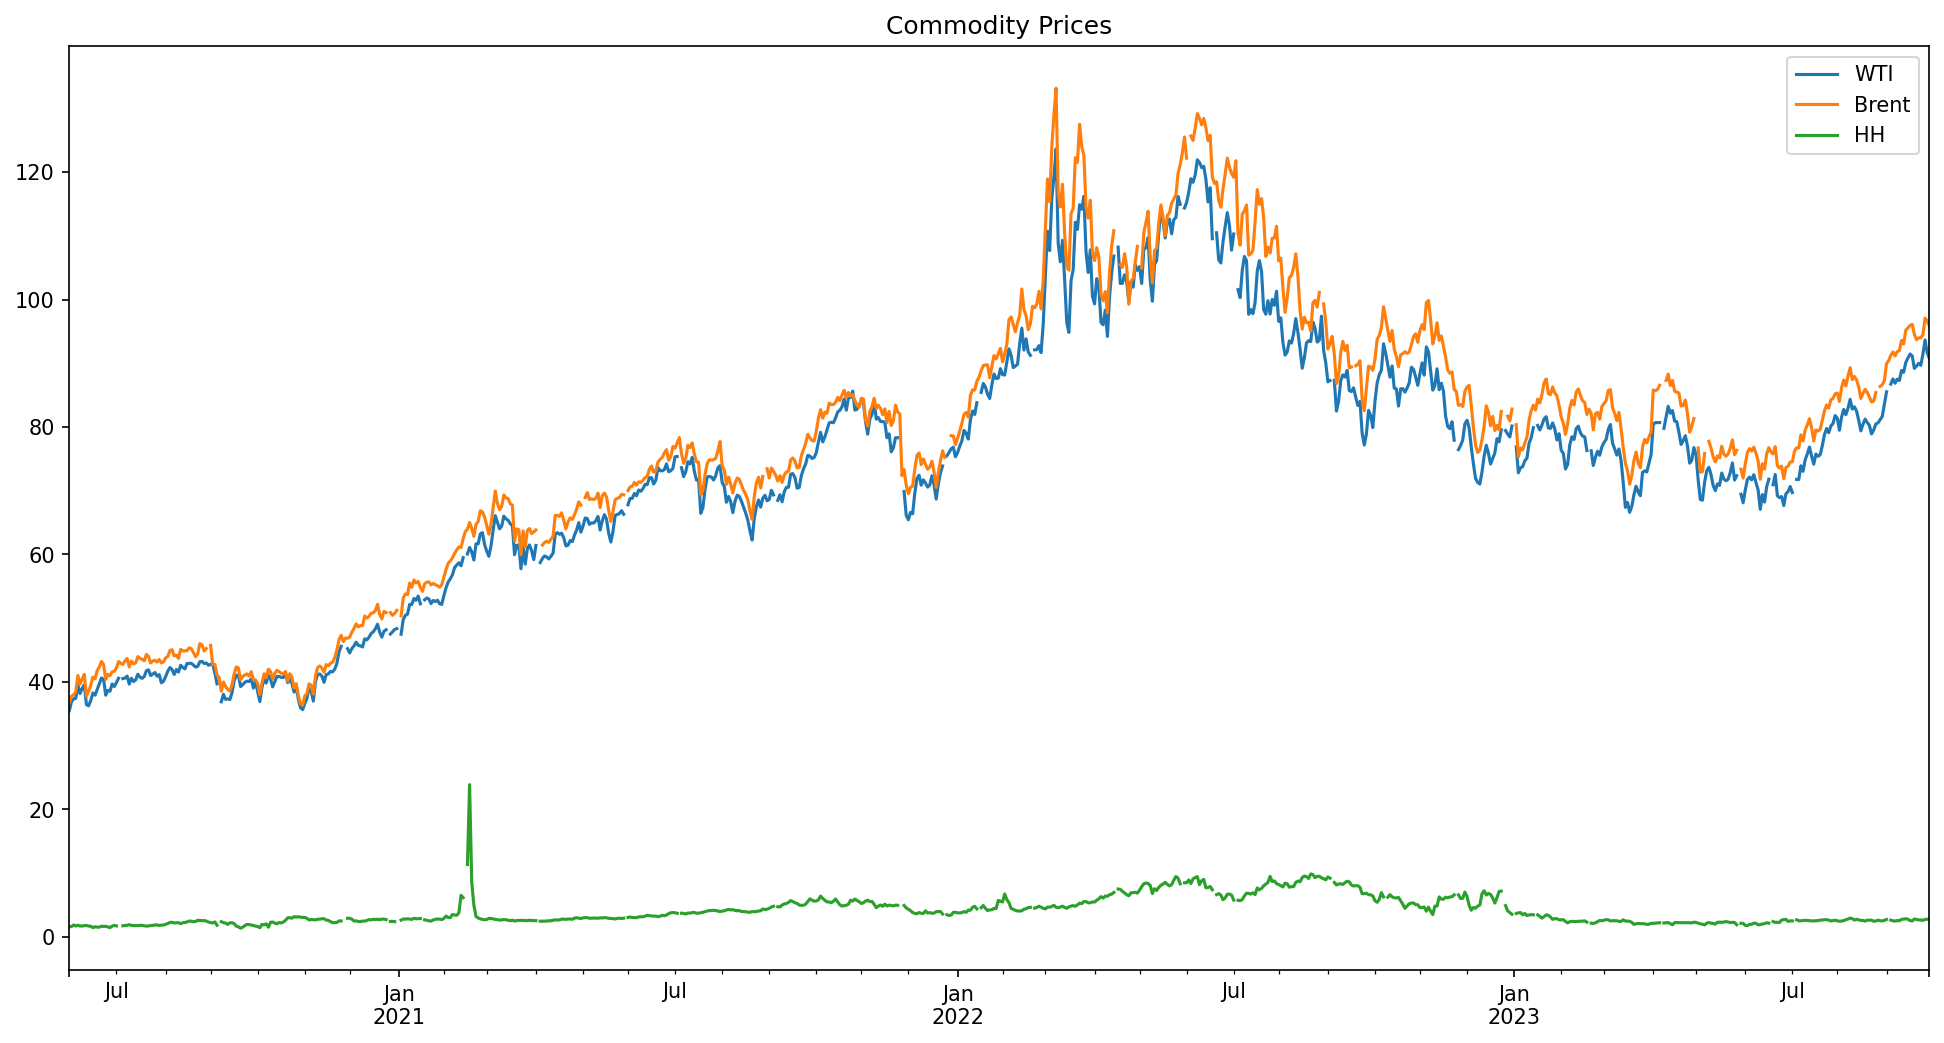

In [5]:
plt.figure(figsize=(16, 8), dpi=150) 

assets['DCOILWTICO'].plot(label='WTI')
assets['DCOILBRENTEU'].plot(label='Brent')
assets['DHHNGSP'].plot(label='HH')
#assets['PNGASEUUSDM'].plot(label='TTF')

plt.title('Commodity Prices')
plt.legend()

In [6]:
returns = pd.DataFrame.from_dict(assets).fillna(method='ffill')

for ticker in tickers:
    returns['Ret_' + ticker] = np.log(returns[ticker]) - np.log(returns[ticker].shift(1))

returns = returns.dropna() # only nulls left are the starting returns; will also have an issue with negative prices when series extended back far enough

returns.head()

,DCOILWTICO,DCOILBRENTEU,DHHNGSP,Ret_DCOILWTICO,Ret_DCOILBRENTEU,Ret_DHHNGSP
2020-06-02,36.88,37.72,1.58,0.038418,0.026324,-0.006309
2020-06-03,37.33,37.98,1.84,0.012128,0.006869,0.152341
2020-06-04,37.42,38.41,1.68,0.002408,0.011258,-0.090972
2020-06-05,39.49,41.00,1.80,0.053842,0.065254,0.068993
2020-06-08,38.17,39.66,1.68,-0.033998,-0.033229,-0.068993


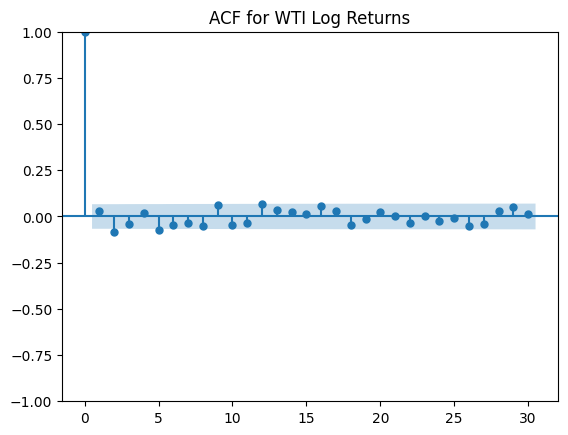

In [7]:
series_wti = returns['Ret_DCOILWTICO']

acf_ret_wti = acf(series_wti)
plot_acf(series_wti, lags=30, title='ACF for WTI Log Returns')
plt.show()

ACF of log returns indicates some AR/MA property among returns with lags 2, 5, 9, 12 being statistically significant

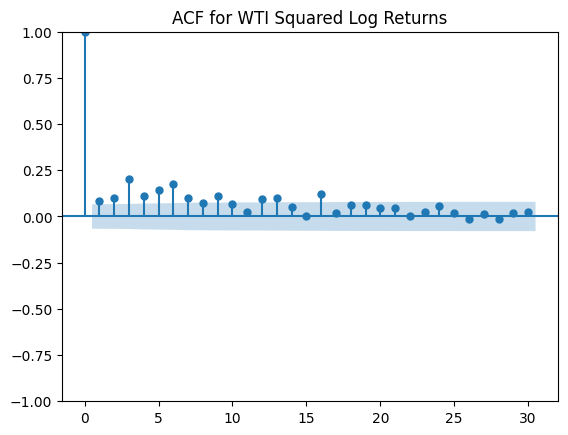

In [9]:
acf_retsq_wti = acf(series_wti**2)
plot_acf(series_wti**2, lags=30, title='ACF for WTI Squared Log Returns')
plt.show()

ACF of squared log returns indicates some AR property among squared returns for (G)ARCH with lags up to 9 and several others being statistically significant

In [10]:
describe(series_wti)

,Ret_DCOILWTICO
nobs,8.690000e+02
missing,0.000000e+00
mean,1.080642e-03
std_err,8.235387e-04
upper_ci,2.694748e-03
lower_ci,-5.334643e-04
std,2.427694e-02
iqr,2.791480e-02
iqr_normal,2.069327e-02
mad,1.793358e-02


negative skewness

high kurtosis

jarque_bera_pval close to zero --> H0 normality rejected

In [12]:
mu, sigma = np.mean(series_wti), np.std(series_wti)
x = np.random.normal(mu, sigma, 1000)
x = pd.Series(x, name='Normal Distribution')

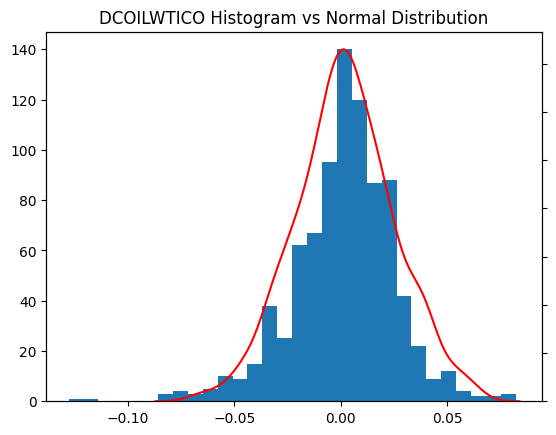

In [13]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.grid(False)
ax1.hist(series_wti, bins=30)
g1 = sns.kdeplot(x, ax=ax2, color='r')
g1.set(ylabel=None)
g1.set(yticklabels=[])
plt.title('DCOILWTICO Histogram vs Normal Distribution');

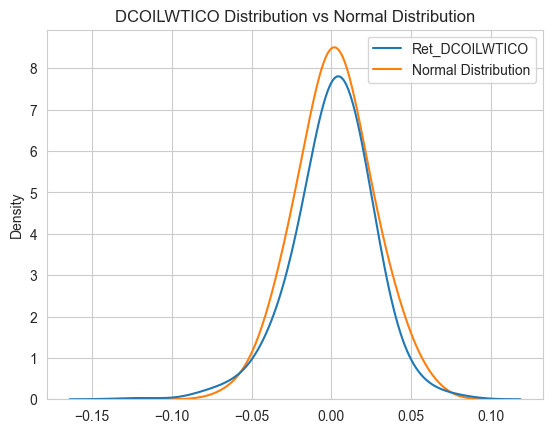

In [14]:
sns.set_style('whitegrid')
series_wti_norm = pd.concat([series_wti, x], axis=1)
sns.kdeplot(data=series_wti_norm, bw_method=0.5)
plt.title('DCOILWTICO Distribution vs Normal Distribution');

Leptokurtic distribution

Negative skew

Fat tails, particularly for negative returns

In [15]:
arch_test = het_arch(series_wti)
arch_test

(74.01086220849128,
 7.409383379921156e-12,
 7.995169376403505,
 2.158539007848078e-12)

In [16]:
arch_test = het_arch(series_wti, nlags=5)
arch_test

(58.30251863526131,
 2.7243829457468232e-11,
 12.417454974371093,
 1.1881259650242177e-11)

H0 no arch effects rejected (p-value close to zero)

## Model Run

In [8]:
proportion_in_train = 0.9
split = int(proportion_in_train*len(series_wti))

series_wti_train = series_wti.iloc[:split]
series_wti_test = series_wti.iloc[split+1:]

In [91]:
class garch:
    def __init__(self, p, q, mean, train, test, lags=0, o=0):
        self.p = p
        self.o = o
        self.q = q
        self.mean = mean
        self.lags = lags        
        self.train = train
        self.test = test
        self.res_garch = self.fit()
        self.forecast = self.forecast()
        self.forecast_vs_test = self.forecast_vs_test()
    
    def fit(self):
        garch = arch.arch_model(self.train, mean=self.mean, lags=self.lags, vol='GARCH', p=self.p, o=self.o, q=self.q)
        res_garch = garch.fit()
                
        return res_garch

    def summary(self):
        res_garch_summary = self.res_garch.summary()
        
        return res_garch_summary
    
    def plot(self):
        fig = self.res_garch.plot()
        plt.show()
    
    def autocorr(self):
        lb = acorr_ljungbox(self.res_garch.std_resid**2, [10, 15, 20])
        
        return lb
    
    def info_crit(self):
        ic_out = {'AIC': [self.res_garch.aic], 'BIC': [self.res_garch.bic]}
        ic = pd.DataFrame(data=ic_out)
        
        return ic
    
    def acf_stan(self):
        plot_acf(self.res_garch.std_resid, lags=30, title='ACF of Standardized Residuals')
        plt.show()
        
    def acf_sq_stan(self):
        plot_acf(self.res_garch.std_resid**2, lags=30, title='ACF of Squared Standardized Residuals')
        plt.show()
        
    def forecast(self):
        forecast = self.res_garch.forecast(horizon=len(self.test))
        
        return forecast
    
    def forecast_mean(self):
        forecast_mean = self.forecast.mean
        forecast_mean.iloc[0].plot()
        
    def forecast_stdev(self):
        forecast_stdev = self.forecast.variance**0.5
        forecast_stdev.iloc[0].plot()
    
    def forecast_vs_test(self):
        forecast_mean = pd.Series(self.forecast.mean.iloc[0].values, index=self.test.index)
        self.train.rename('Ret_Train', inplace=True)
        self.test.rename('Ret_Test', inplace=True)
        forecast_mean.rename('Ret_Forecast', inplace=True)
        forecast_vs_test = pd.concat([self.train, self.test, forecast_mean], axis=1)

        forecast_vs_test['Ret_Test_Broad'] = forecast_vs_test[['Ret_Train','Ret_Test']].max(axis=1)

        forecast_vs_test['Vol_Train'] = forecast_vs_test[['Ret_Train']].rolling(30).std().shift(1) #30d std dev
        forecast_vs_test['Vol_Test_Broad'] = forecast_vs_test[['Ret_Test_Broad']].rolling(30).std().shift(1) #30d std dev
        forecast_vs_test['Vol_Test'] = np.where(forecast_vs_test['Ret_Test'].isna(), forecast_vs_test['Ret_Test'], forecast_vs_test['Vol_Test_Broad'])

        forecast_vs_test_condvol = pd.Series((self.forecast.variance**0.5).iloc[0].values, index=self.test.index) #conditional vol
        forecast_vs_test_condvol.rename('Vol_Forecast', inplace=True)
        forecast_vs_test = pd.concat([forecast_vs_test, forecast_vs_test_condvol], axis=1)

        return forecast_vs_test
    
    def forecast_vs_test_mean_plot(self):
        self.forecast_vs_test[['Ret_Train','Ret_Test','Ret_Forecast']].plot()
        
    def forecast_vs_test_vol_plot(self):
        self.forecast_vs_test[['Vol_Train','Vol_Test','Vol_Forecast']].plot()

In [61]:
garch11 = garch(1, 1, 'Zero', series_wti_train, series_wti_test)

Iteration:      1,   Func. Count:      4,   Neg. LLF: -1809.999300967107
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1809.999301378689
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1


C:\Users\afost\Documents\UW\Y2\S1\Thesis\cmd_forecast\Model\venv\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006226. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [51]:
garch11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:         Ret_DCOILWTICO   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                1810.00
Distribution:                  Normal   AIC:                          -3614.00
Method:            Maximum Likelihood   BIC:                          -3600.01
                                        No. Observations:                  782
Date:                Sun, Dec 03 2023   Df Residuals:                      782
Time:                        14:38:53   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.2330e-05  1.267e-05      4.918  8.741e-07 [3.749e-05,8.717e-05]
alpha[1]       0.1000  2.641e-02      3.786  1.531e-04   [4.823e-02,  0.152]
beta[1]        0.8000  2.713e-02     29.485 4.478e-191     [  0.747,  0.853]
============================================================================

Covariance estimator: robust
"""

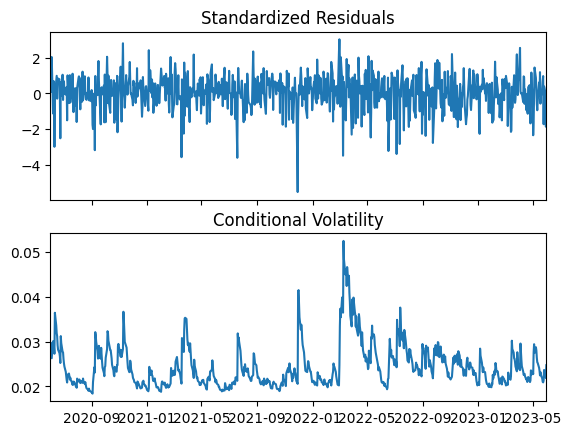

In [62]:
garch11.plot()

In [55]:
garch11.autocorr()

,lb_stat,lb_pvalue
10,5.827400,0.829550
15,10.114137,0.812500
20,12.494963,0.897987


In [56]:
garch11.info_crit()

,AIC,BIC
0,-3613.998603,-3600.013039


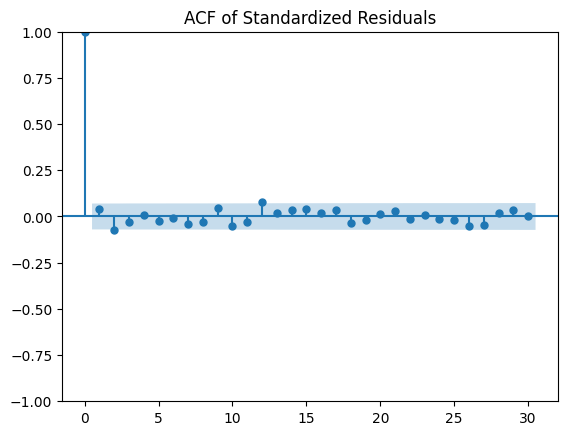

In [57]:
garch11.acf_stan()

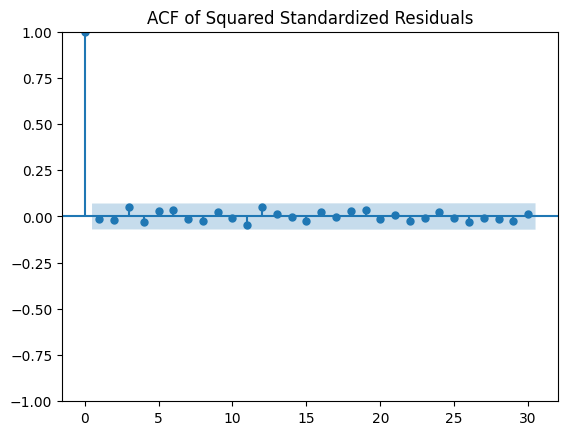

In [58]:
garch11.acf_sq_stan()

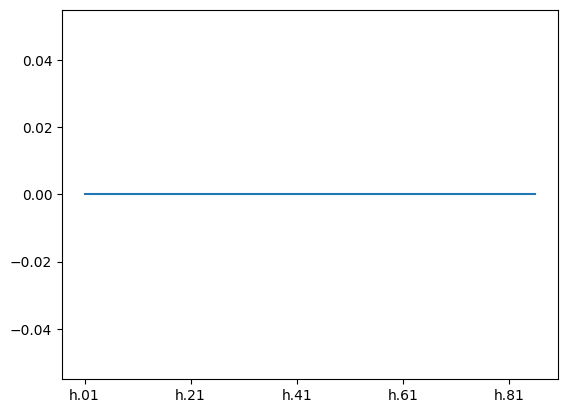

In [58]:
garch11.forecast_mean()

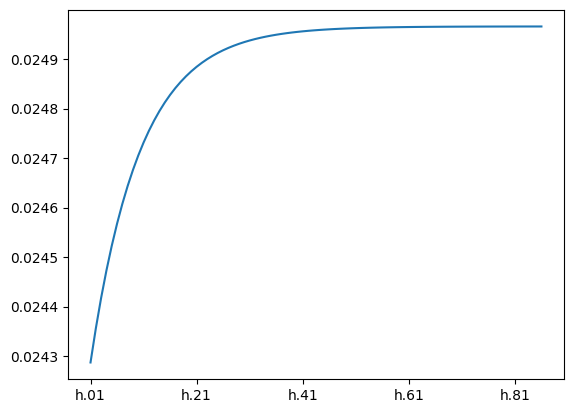

In [59]:
garch11.forecast_stdev()

In [49]:
garch11.forecast_vs_test

,Ret_Train,Ret_Test,Ret_Forecast,Ret_Test_Broad,Vol_Train,Vol_Test_Broad,Vol_Test,Vol_Forecast
2020-06-02,0.038418,NaN,NaN,0.038418,NaN,NaN,NaN,NaN
2020-06-03,0.012128,NaN,NaN,0.012128,NaN,NaN,NaN,NaN
2020-06-04,0.002408,NaN,NaN,0.002408,NaN,NaN,NaN,NaN
2020-06-05,0.053842,NaN,NaN,0.053842,NaN,NaN,NaN,NaN
2020-06-08,-0.033998,NaN,NaN,-0.033998,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-09-25,NaN,-0.003562,0.0,-0.003562,NaN,0.012104,0.012104,0.024966
2023-09-26,NaN,0.019326,0.0,0.019326,NaN,0.011994,0.011994,0.024966
2023-09-27,NaN,0.024204,0.0,0.024204,NaN,0.011721,0.011721,0.024966
2023-09-28,NaN,-0.021801,0.0,-0.021801,NaN,0.011317,0.011317,0.024966


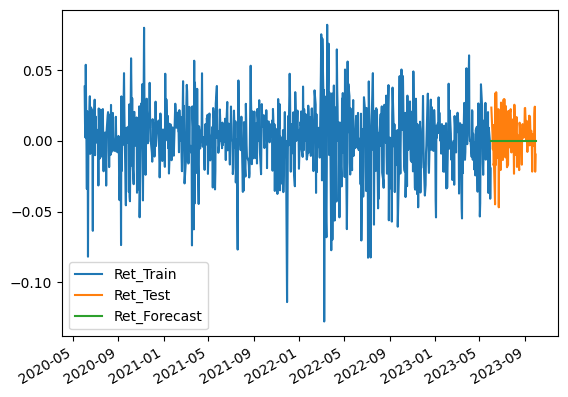

In [53]:
garch11.forecast_vs_test_mean_plot()

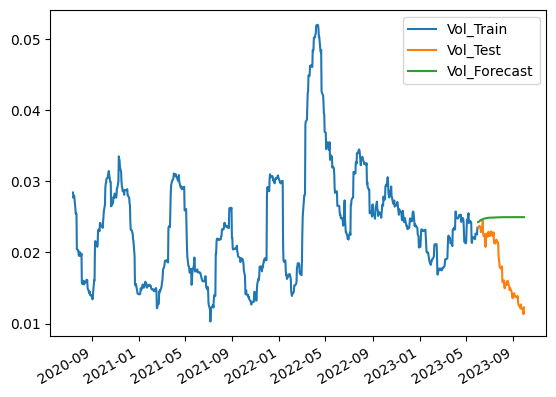

In [54]:
garch11.forecast_vs_test_vol_plot()

All coefficients are statistically significant at 5% confidence level after removing the insignificant mean equation constant

Ljung-Box test on squared standardised residuals: H0 no autocorrelation not rejected at 5% at all 10, 15 & 20 lags

ACF of squared standardised residuals suggests the conditional variance equation is complete - although will see what GARCH(2,1) & GARCH(1,2) produce

ACF of standardised residuals suggets the mean equation can be modified - AR(2), AR(12) to be added

Prediction is run for the chosen number of days from the last available observation by default. The mean equation continues to be 0 as per the zero mean equation definition at the model setup stage. The variance equation evolves according to GARCH(1,1).

In [64]:
garch12 = garch(1, 2, 'Zero', series_wti_train, series_wti_test)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 430674578.1245966
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3096.948508549705
Iteration:      3,   Func. Count:     20,   Neg. LLF: -1809.7533851917592
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1809.753385529647
            Iterations: 7
            Function evaluations: 20
            Gradient evaluations: 3


C:\Users\afost\Documents\UW\Y2\S1\Thesis\cmd_forecast\Model\venv\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006226. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [65]:
garch12.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:              Ret_Train   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                1809.75
Distribution:                  Normal   AIC:                          -3611.51
Method:            Maximum Likelihood   BIC:                          -3592.86
                                        No. Observations:                  782
Date:                Sun, Dec 03 2023   Df Residuals:                      782
Time:                        20:29:36   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.1552e-05  1.430e-05      4.304  1.680e-05 [3.352e-05,8.958e-05]
alpha[1]       0.1013  2.697e-02      3.754  1.738e-04   [4.839e-02,  0.154]
beta[1]        0.3975      0.300      1.324      0.186     [ -0.191,  0.986]
beta[2]        0.3975      0.280      1.421      0.155     [ -0.151,  0.946]
============================================================================

Covariance estimator: robust
"""

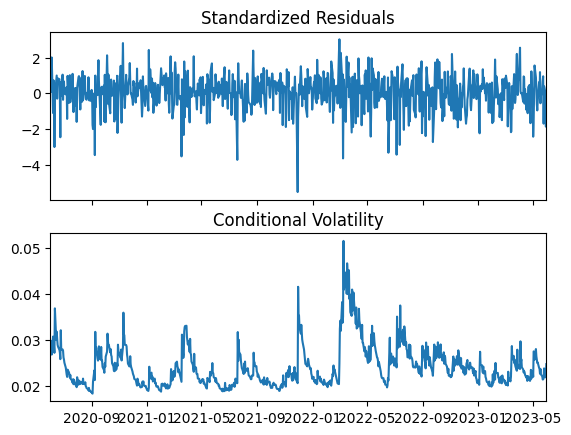

In [66]:
garch12.plot()

In [68]:
garch12.autocorr()

,lb_stat,lb_pvalue
10,6.960930,0.729128
15,11.406897,0.723253
20,13.349407,0.861894


In [69]:
garch12.info_crit()

,AIC,BIC
0,-3611.506771,-3592.859352


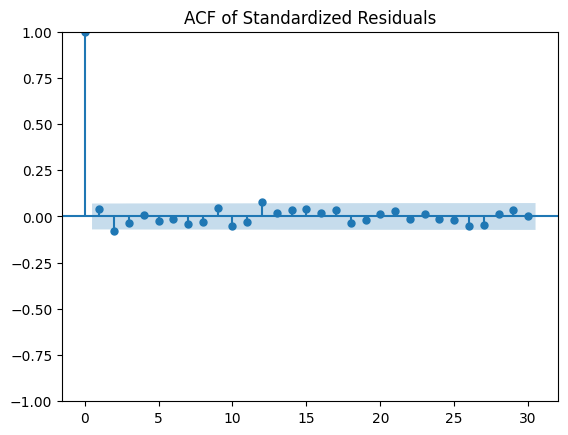

In [70]:
garch12.acf_stan()

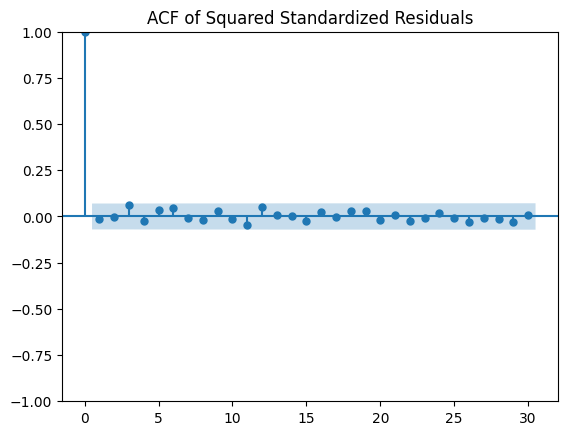

In [71]:
garch12.acf_sq_stan()

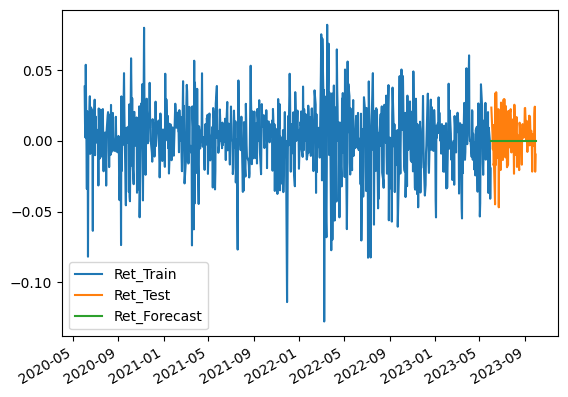

In [72]:
garch12.forecast_vs_test_mean_plot()

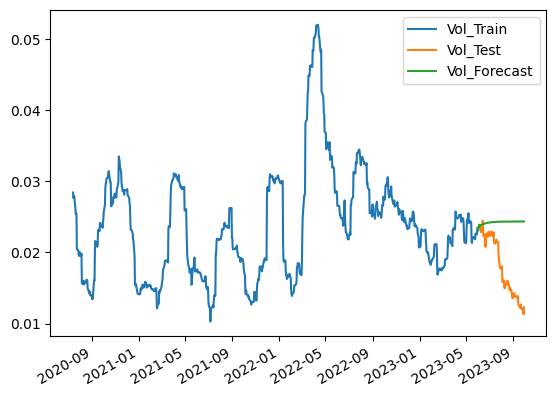

In [73]:
garch12.forecast_vs_test_vol_plot()

In [74]:
garch21 = garch(2, 1, 'Zero', series_wti_train, series_wti_test)

Iteration:      1,   Func. Count:      5,   Neg. LLF: -1810.5961885203112
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1810.596189290977
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1


C:\Users\afost\Documents\UW\Y2\S1\Thesis\cmd_forecast\Model\venv\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006226. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [75]:
garch21.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:              Ret_Train   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                1810.60
Distribution:                  Normal   AIC:                          -3613.19
Method:            Maximum Likelihood   BIC:                          -3594.54
                                        No. Observations:                  782
Date:                Sun, Dec 03 2023   Df Residuals:                      782
Time:                        20:33:07   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.2330e-05  1.221e-05      5.106  3.292e-07 [3.840e-05,8.626e-05]
alpha[1]       0.0500  3.532e-02      1.416      0.157  [-1.922e-02,  0.119]
alpha[2]       0.0500  3.755e-02      1.332      0.183  [-2.359e-02,  0.124]
beta[1]        0.8000  2.799e-02     28.583 1.083e-179     [  0.745,  0.855]
============================================================================

Covariance estimator: robust
"""

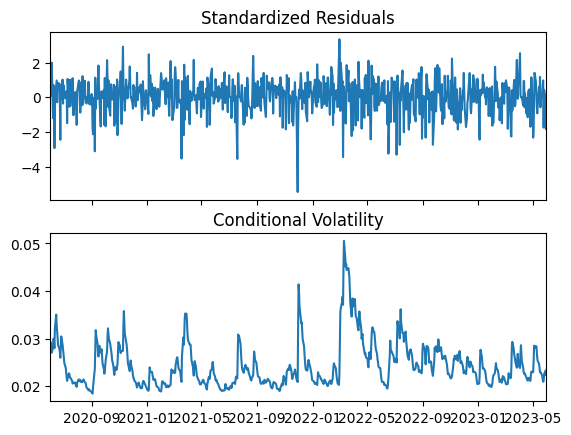

In [76]:
garch21.plot()

In [77]:
garch21.autocorr()

,lb_stat,lb_pvalue
10,5.909589,0.822801
15,9.926634,0.824329
20,12.458637,0.899386


In [78]:
garch21.info_crit()

,AIC,BIC
0,-3613.192379,-3594.54496


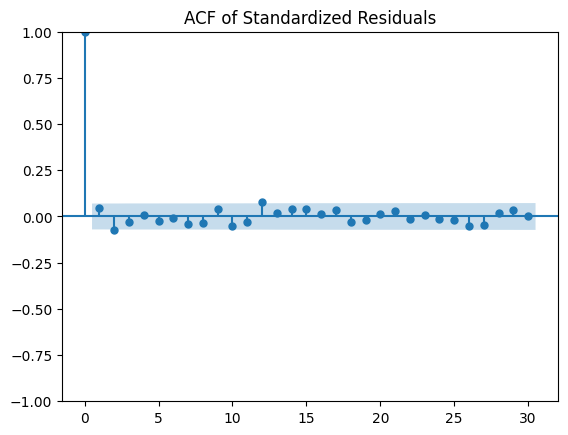

In [79]:
garch21.acf_stan()

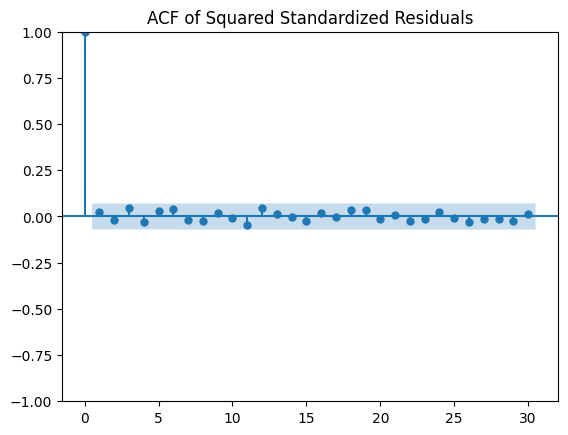

In [80]:
garch21.acf_sq_stan()

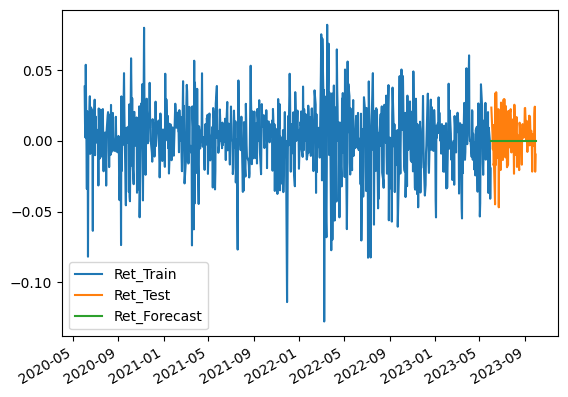

In [81]:
garch21.forecast_vs_test_mean_plot()

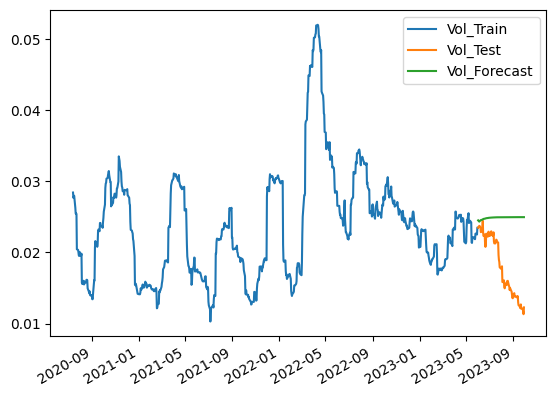

In [82]:
garch21.forecast_vs_test_vol_plot()

In [108]:
ar1garch11 = garch(1, 1, 'AR', series_wti_train, series_wti_test, 1)

Iteration:      1,   Func. Count:      7,   Neg. LLF: 1.6790483056202746e+17
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4117770.473152471
Iteration:      3,   Func. Count:     31,   Neg. LLF: 1.3486835091940908e+16
Iteration:      4,   Func. Count:     43,   Neg. LLF: 350541.40034796746
Iteration:      5,   Func. Count:     55,   Neg. LLF: 4372527.965436871
Iteration:      6,   Func. Count:     66,   Neg. LLF: -1809.3839874231512
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1809.3839877577075
            Iterations: 10
            Function evaluations: 66
            Gradient evaluations: 6


C:\Users\afost\Documents\UW\Y2\S1\Thesis\cmd_forecast\Model\venv\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006207. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [109]:
ar1garch11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:              Ret_Train   R-squared:                       0.001
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1809.38
Distribution:                  Normal   AIC:                          -3608.77
Method:            Maximum Likelihood   BIC:                          -3585.47
                                        No. Observations:                  781
Date:                Sun, Dec 03 2023   Df Residuals:                      779
Time:                        21:41:48   Df Model:                            2
                                   Mean Model                                  
===============================================================================
                   coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------------------------------------------------------------------
Const        1.0592e-03  7.972e-04      1.329      0.184 [-5.033e-04,2.622e-03]
Ret_Train[1]     0.0378  3.845e-02      0.983      0.325   [-3.755e-02,  0.113]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.2082e-05  1.343e-05      4.623  3.783e-06 [3.576e-05,8.840e-05]
alpha[1]       0.1000  2.664e-02      3.754  1.742e-04   [4.779e-02,  0.152]
beta[1]        0.8000  2.734e-02     29.260 3.318e-188     [  0.746,  0.854]
============================================================================

Covariance estimator: robust
"""

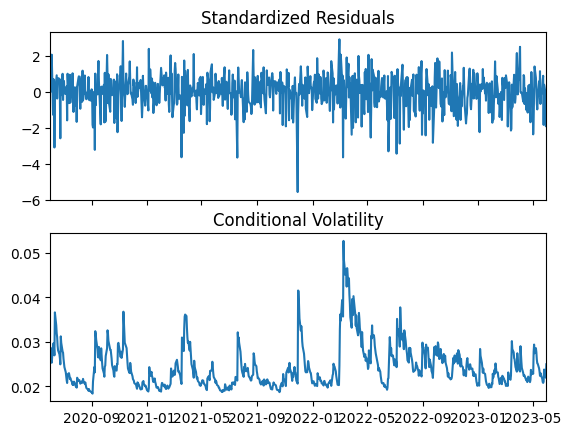

In [110]:
ar1garch11.plot()

In [112]:
ar1garch11.autocorr()

,lb_stat,lb_pvalue
10,NaN,NaN
15,NaN,NaN
20,NaN,NaN


In [113]:
ar1garch11.info_crit()

,AIC,BIC
0,-3608.767976,-3585.4651


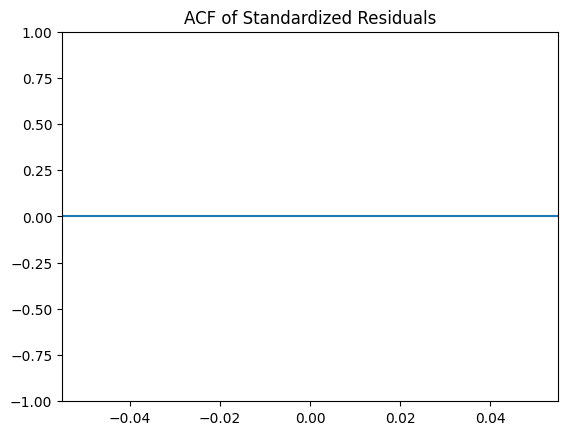

In [114]:
ar1garch11.acf_stan()

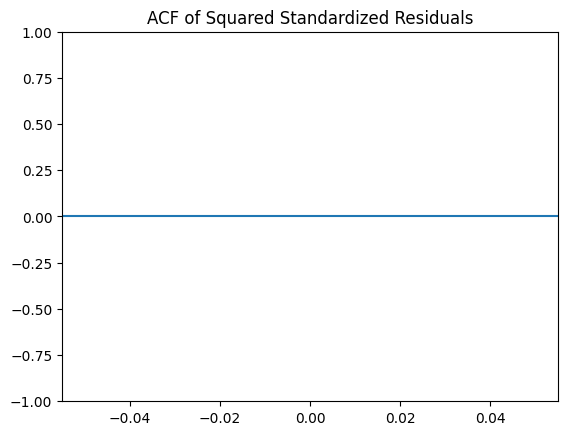

In [116]:
ar1garch11.acf_sq_stan()

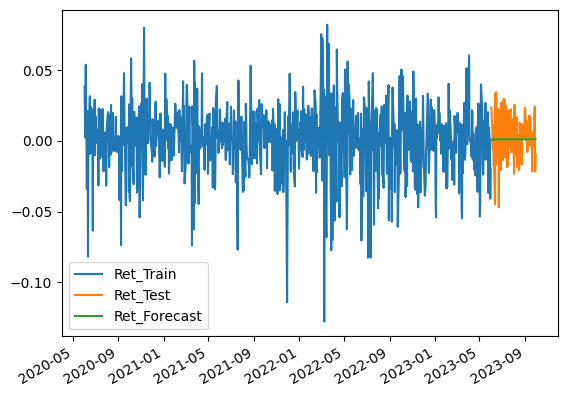

In [117]:
ar1garch11.forecast_vs_test_mean_plot()

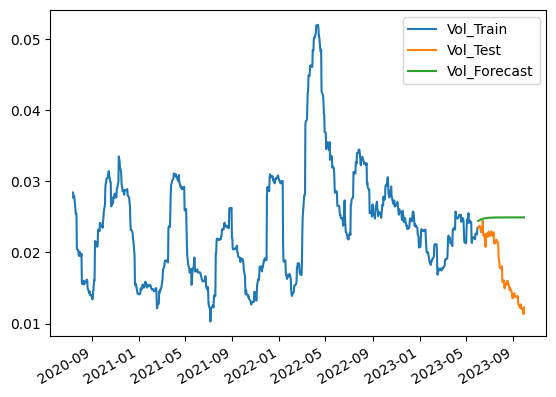

In [118]:
ar1garch11.forecast_vs_test_vol_plot()

In [119]:
ar2garch11 = garch(1, 1, 'AR', series_wti_train, series_wti_test, 2)

Iteration:      1,   Func. Count:      8,   Neg. LLF: 127389626.12736216
Iteration:      2,   Func. Count:     21,   Neg. LLF: 336963530.11198455
Iteration:      3,   Func. Count:     34,   Neg. LLF: 53220476.81096439
Iteration:      4,   Func. Count:     47,   Neg. LLF: 81090998.22011365
Iteration:      5,   Func. Count:     60,   Neg. LLF: 22918052.043702397
Iteration:      6,   Func. Count:     74,   Neg. LLF: 23844200563.732056
Iteration:      7,   Func. Count:     83,   Neg. LLF: -1809.7140754022753
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1809.7140755639277
            Iterations: 11
            Function evaluations: 83
            Gradient evaluations: 7


C:\Users\afost\Documents\UW\Y2\S1\Thesis\cmd_forecast\Model\venv\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006165. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [120]:
ar2garch11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:              Ret_Train   R-squared:                       0.009
Mean Model:                        AR   Adj. R-squared:                  0.006
Vol Model:                      GARCH   Log-Likelihood:                1809.71
Distribution:                  Normal   AIC:                          -3607.43
Method:            Maximum Likelihood   BIC:                          -3579.47
                                        No. Observations:                  780
Date:                Sun, Dec 03 2023   Df Residuals:                      777
Time:                        21:44:03   Df Model:                            3
                                   Mean Model                                  
===============================================================================
                   coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------------------------------------------------------------------
Const        1.3744e-03  8.125e-04      1.692  9.070e-02 [-2.180e-04,2.967e-03]
Ret_Train[1]     0.0365  3.915e-02      0.931      0.352   [-4.029e-02,  0.113]
Ret_Train[2]    -0.0867  3.871e-02     -2.240  2.509e-02   [ -0.163,-1.084e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.1620e-05  1.312e-05      4.696  2.655e-06 [3.590e-05,8.734e-05]
alpha[1]       0.0999  2.705e-02      3.693  2.219e-04   [4.688e-02,  0.153]
beta[1]        0.7992  2.889e-02     27.660 2.123e-168     [  0.743,  0.856]
============================================================================

Covariance estimator: robust
"""

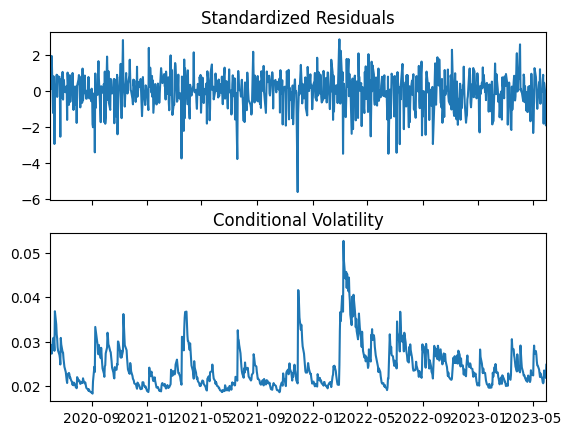

In [121]:
ar2garch11.plot()

In [122]:
ar2garch11.autocorr()

,lb_stat,lb_pvalue
10,NaN,NaN
15,NaN,NaN
20,NaN,NaN


In [123]:
ar2garch11.info_crit()

,AIC,BIC
0,-3607.428151,-3579.472388


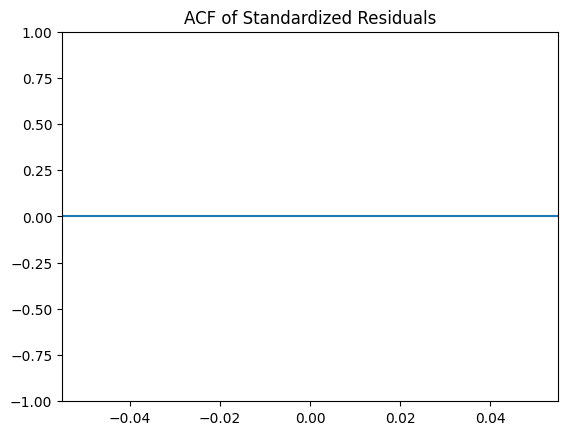

In [124]:
ar2garch11.acf_stan()

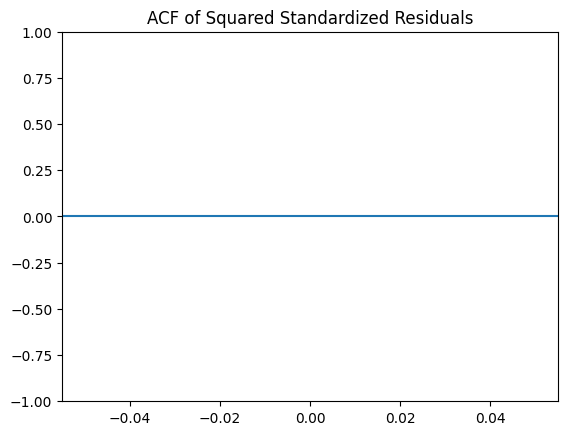

In [125]:
ar2garch11.acf_sq_stan()

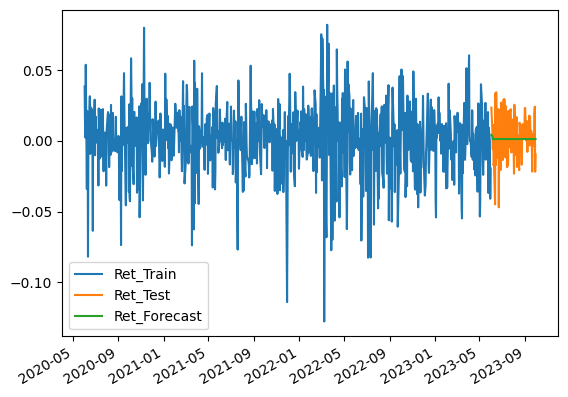

In [126]:
ar2garch11.forecast_vs_test_mean_plot()

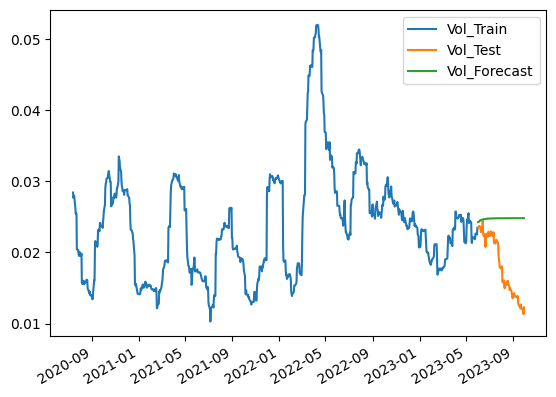

In [127]:
ar2garch11.forecast_vs_test_vol_plot()

In [131]:
ar12garch11 = garch(1, 2, 'AR', series_wti_train, series_wti_test, 12)

Iteration:      1,   Func. Count:     19,   Neg. LLF: 75748956.19422024
Iteration:      2,   Func. Count:     43,   Neg. LLF: 6496.272387078561
Iteration:      3,   Func. Count:     63,   Neg. LLF: -1797.1236106577337
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1797.123612765142
            Iterations: 7
            Function evaluations: 63
            Gradient evaluations: 3


C:\Users\afost\Documents\UW\Y2\S1\Thesis\cmd_forecast\Model\venv\Lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005885. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [132]:
ar12garch11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:              Ret_Train   R-squared:                       0.037
Mean Model:                        AR   Adj. R-squared:                  0.022
Vol Model:                      GARCH   Log-Likelihood:                1797.12
Distribution:                  Normal   AIC:                          -3560.25
Method:            Maximum Likelihood   BIC:                          -3481.26
                                        No. Observations:                  770
Date:                Sun, Dec 03 2023   Df Residuals:                      757
Time:                        21:47:24   Df Model:                           13
                                   Mean Model                                   
================================================================================
                    coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------------------------------------------------------
Const         1.5642e-03  8.859e-04      1.766  7.746e-02 [-1.722e-04,3.301e-03]
Ret_Train[1]      0.0439  3.795e-02      1.156      0.248   [-3.050e-02,  0.118]
Ret_Train[2]     -0.0805  3.836e-02     -2.099  3.582e-02   [ -0.156,-5.332e-03]
Ret_Train[3]     -0.0611  4.092e-02     -1.492      0.136    [ -0.141,1.915e-02]
Ret_Train[4]      0.0137  3.489e-02      0.394      0.694 [-5.465e-02,8.211e-02]
Ret_Train[5]     -0.0703  4.178e-02     -1.682  9.252e-02    [ -0.152,1.160e-02]
Ret_Train[6]     -0.0141  3.932e-02     -0.359      0.720 [-9.117e-02,6.296e-02]
Ret_Train[7]     -0.0335  3.435e-02     -0.974      0.330    [ -0.101,3.386e-02]
Ret_Train[8]     -0.0572  3.505e-02     -1.633      0.102    [ -0.126,1.146e-02]
Ret_Train[9]      0.0664  3.639e-02      1.826  6.787e-02   [-4.881e-03,  0.138]
Ret_Train[10]    -0.0654  3.465e-02     -1.888  5.907e-02    [ -0.133,2.505e-03]
Ret_Train[11]    -0.0308  3.266e-02     -0.944      0.345 [-9.483e-02,3.319e-02]
Ret_Train[12]     0.0496  3.796e-02      1.307      0.191   [-2.477e-02,  0.124]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.5075e-05  1.705e-05      3.817  1.351e-04 [3.166e-05,9.849e-05]
alpha[1]       0.1010  3.446e-02      2.930  3.391e-03   [3.342e-02,  0.169]
beta[1]        0.3996      0.304      1.317      0.188     [ -0.195,  0.994]
beta[2]        0.3996      0.281      1.424      0.155     [ -0.150,  0.950]
============================================================================

Covariance estimator: robust
"""

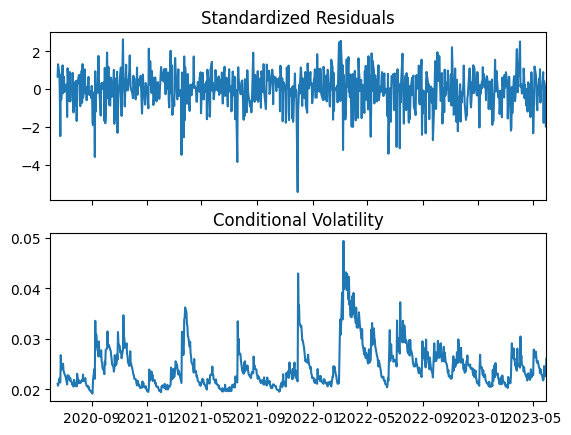

In [133]:
ar12garch11.plot()

In [134]:
ar12garch11.autocorr()

,lb_stat,lb_pvalue
10,NaN,NaN
15,NaN,NaN
20,NaN,NaN


In [135]:
ar12garch11.info_crit()

,AIC,BIC
0,-3560.247226,-3481.258587


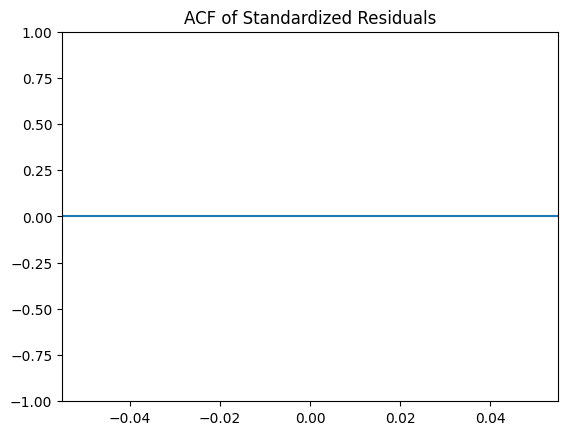

In [136]:
ar12garch11.acf_stan()

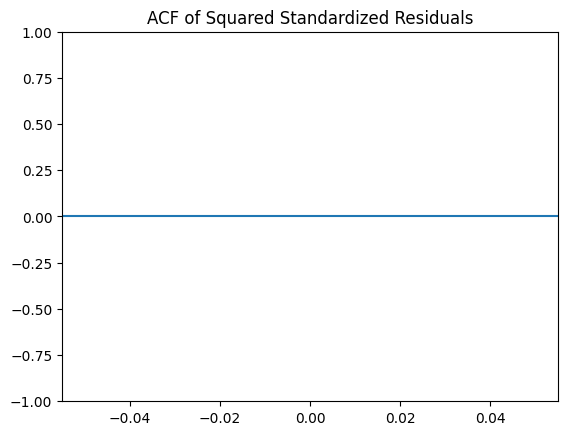

In [137]:
ar12garch11.acf_sq_stan()

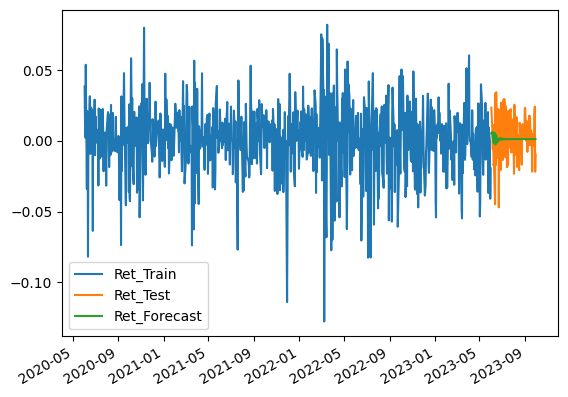

In [138]:
ar12garch11.forecast_vs_test_mean_plot()

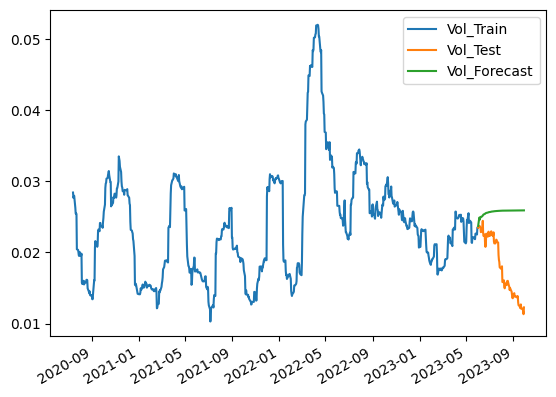

In [139]:
ar12garch11.forecast_vs_test_vol_plot()

Add GJR-GARCH, TARCH and trading strategy logic

In [145]:
ar2garch11.forecast.mean

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10,...,h.77,h.78,h.79,h.80,h.81,h.82,h.83,h.84,h.85,h.86
2023-05-31,0.004211,0.003217,0.001127,0.001137,0.001318,0.001324,0.001308,0.001307,0.001309,0.001309,...,0.001309,0.001309,0.001309,0.001309,0.001309,0.001309,0.001309,0.001309,0.001309,0.001309


In [146]:
ar2garch11.forecast.variance**0.5

,h.01,h.02,h.03,h.04,h.05,h.06,h.07,h.08,h.09,h.10,...,h.77,h.78,h.79,h.80,h.81,h.82,h.83,h.84,h.85,h.86
2023-05-31,0.024276,0.024336,0.024464,0.0245,0.024533,0.024562,0.024588,0.024612,0.024633,0.024652,...,0.024819,0.024819,0.024819,0.024819,0.024819,0.024819,0.024819,0.024819,0.024819,0.024819


In [147]:
ar2garch11.forecast_vs_test

,Ret_Train,Ret_Test,Ret_Forecast,Ret_Test_Broad,Vol_Train,Vol_Test_Broad,Vol_Test,Vol_Forecast
2020-06-02,0.038418,NaN,NaN,0.038418,NaN,NaN,NaN,NaN
2020-06-03,0.012128,NaN,NaN,0.012128,NaN,NaN,NaN,NaN
2020-06-04,0.002408,NaN,NaN,0.002408,NaN,NaN,NaN,NaN
2020-06-05,0.053842,NaN,NaN,0.053842,NaN,NaN,NaN,NaN
2020-06-08,-0.033998,NaN,NaN,-0.033998,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-09-25,NaN,-0.003562,0.001309,-0.003562,NaN,0.012104,0.012104,0.024819
2023-09-26,NaN,0.019326,0.001309,0.019326,NaN,0.011994,0.011994,0.024819
2023-09-27,NaN,0.024204,0.001309,0.024204,NaN,0.011721,0.011721,0.024819
2023-09-28,NaN,-0.021801,0.001309,-0.021801,NaN,0.011317,0.011317,0.024819
